In [ ]:
# Description: The code trains and tests the model for image classification. In this code, as the dataset
# is of small size, I've used the data generator for data augmentation and then repeated the dataset
# using the repeat() function for 25 times. In this code, I tried to run the model for 100 epochs,
# however, the model ran for 62 epochs because I used Early Stopping with a patience of 10,
# meaning if the validation loss doesn’t improve for 10 epochs continuously then it stops. I saved
# only that model which gave me minimal validation loss.
# Then I loaded the model that I saved and used it on the testing dataset and the model’s testing
# accuracy was about 98%

In [1]:
# importing all the necessary libraries
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
# defining image shape of 150*150
im_shape = (150,150)

# directory for training dataset
TRAINING_DIR = r'C:\Users\Desktop\Bird\Training'
# directory for testing dataset
TEST_DIR = r'C:\Users\Desktop\Bird\Testing'

seed = 10

BATCH_SIZE = 28

In [3]:
# using Data generator to generate more images which will be similar to the dataset that we have (data augmentation)
# here we are splitting the training data into 2 parts. 80% for training and 20% for validation
# data generator for training dataset
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# data generator for validation dataset
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [4]:
# preparing training dataset, class mode is categorical because we have mare than 2 classes
train_dataset = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

# preparing validation dataset, class mode is categorical because we have mare than 2 classes
validation_dataset = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# preparing the testing dataset, class mode is categorical because we have mare than 2 classes
test_dataset = ImageDataGenerator(rescale=1./255)
test_dataset = test_dataset.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

# this code counts number of samples in each dataset
nb_train_samples = train_dataset.samples
nb_validation_samples = validation_dataset.samples
nb_test_samples = test_dataset.samples
# getting the classes name for our data
classes = list(train_dataset.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 352 images belonging to 4 classes.
Found 88 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Classes: ['PAINTED BUNTIG', 'PEACOCK', 'RAINBOW LORIKEET', 'TAIWAN MAGPIE']


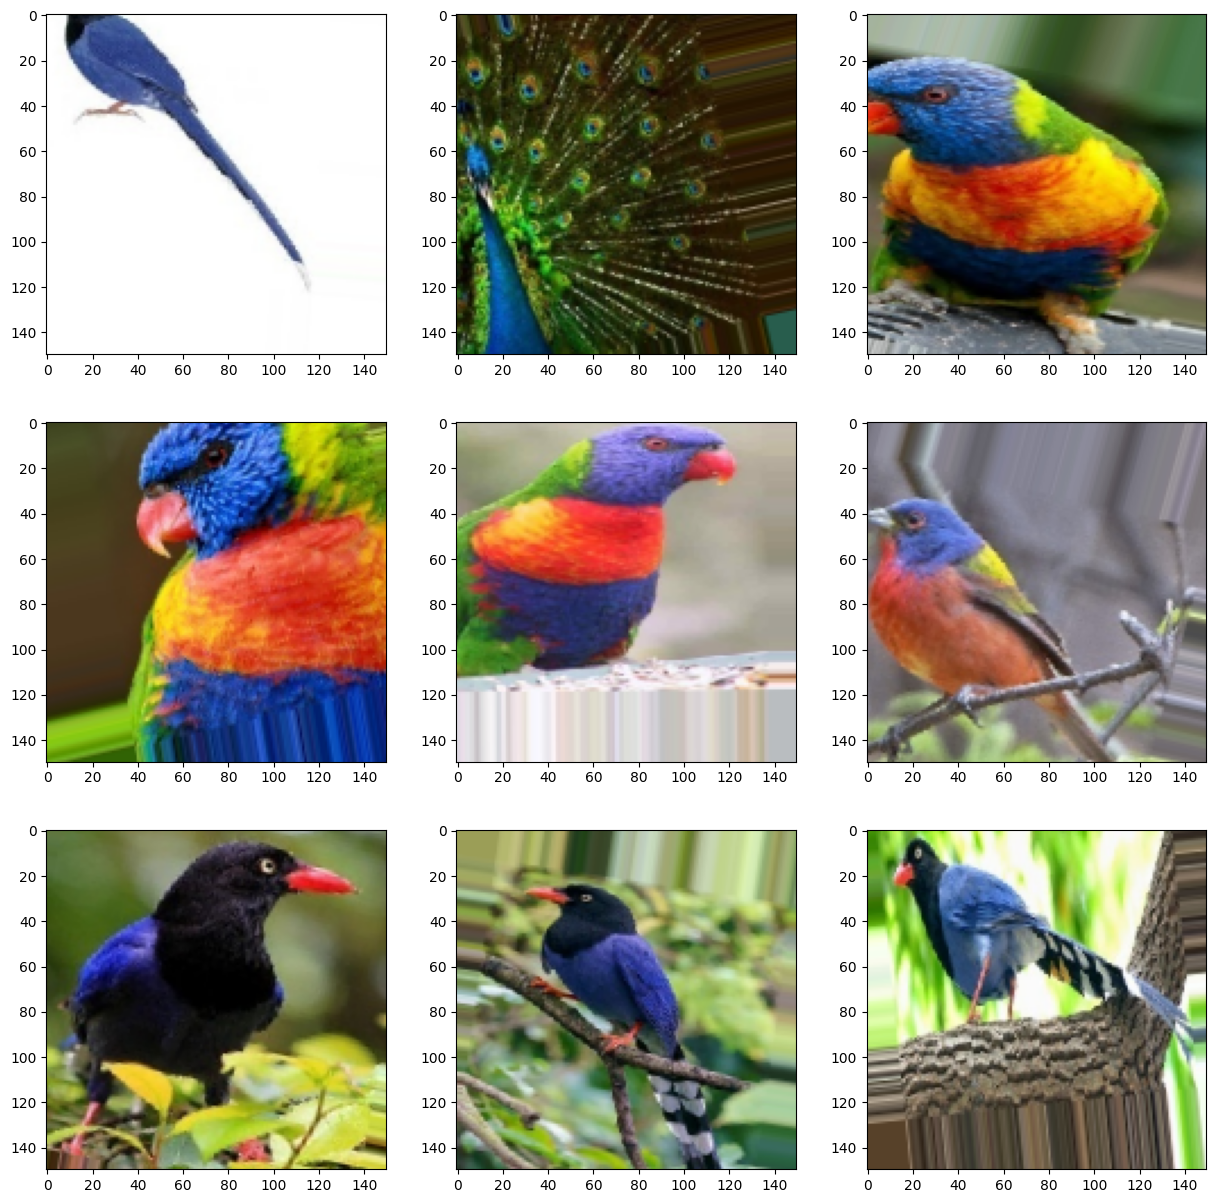

In [5]:
# Visualizing some examples
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_dataset.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [6]:
# Creating a TensorFlow Dataset for the training data
train_generator = tf.data.Dataset.from_generator(
    lambda: train_dataset,  # A lambda function that returns the train_dataset generator
    output_types=(tf.float32, tf.float32),  # Specifies the data types of the output: float32 for both images and labels
    output_shapes=([None, 150, 150, 3], [None, num_classes])  # Defines the shape of the output data
)

# Creating a TensorFlow Dataset for the validation data
validation_generator = tf.data.Dataset.from_generator(
    lambda: validation_dataset,  # A lambda function that returns the validation_dataset generator
    output_types=(tf.float32, tf.float32),  # Similar to train_generator, float32 data type for images and labels
    output_shapes=([None, 150, 150, 3], [None, num_classes])  # Output shapes are the same as train_generator
)

In [7]:
# Repeating the training and validation dataset for 25 times
train_generator = train_generator.repeat(25)
validation_generator = validation_generator.repeat(25)

In [8]:
# defining our model
model = tf.keras.Sequential([
    # First convolutional layer with 32 filters, kernel size of 3x3, ReLU activation, and input shape specified for 250x250 images with 3 channels
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    # Max pooling layer to reduce spatial dimensions (height and width)
    tf.keras.layers.MaxPooling2D(2,2),
    # Dropout layer to reduce overfitting by randomly setting a fraction of the inputs to 0
    tf.keras.layers.Dropout(0.2),
    # Additional convolutional layers with increasing number of filters. Each followed by a max pooling layer and a dropout layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Flatten layer to convert the 3D output of the last convolutional layer to a 1D tensor
    tf.keras.layers.Flatten(),
    # Fully connected (Dense) layer with 512 neurons and ReLU activation
    tf.keras.layers.Dense(512, activation='relu'),
    # Final Dense layer with a number of neurons equal to the number of classes and softmax activation for multi-class classification
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

# compiliing model with adam optiomizer, categorical_crossentropy loss function and accuracy metric for evaluation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

In [9]:
epochs = 100 # train the model for 100 epochs

# Using Callbacks to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1) # we'll stop early if val_loss doesn't changes for 10 epochs continuosly
]

# Training our model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 1.4760 - accuracy: 0.2438
Epoch 1: val_loss improved from inf to 1.38512, saving model to model.h5
12/12 [==============================] - 14s 1s/step - loss: 1.4760 - accuracy: 0.2438 - val_loss: 1.3851 - val_accuracy: 0.4524
Epoch 2/100


C:\Users\saumy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - ETA: 0s - loss: 1.3663 - accuracy: 0.2809
Epoch 2: val_loss improved from 1.38512 to 1.26815, saving model to model.h5
12/12 [==============================] - 11s 878ms/step - loss: 1.3663 - accuracy: 0.2809 - val_loss: 1.2682 - val_accuracy: 0.3500
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 1.2005 - accuracy: 0.3272
Epoch 3: val_loss improved from 1.26815 to 1.02642, saving model to model.h5
12/12 [==============================] - 11s 940ms/step - loss: 1.2005 - accuracy: 0.3272 - val_loss: 1.0264 - val_accuracy: 0.6333
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 1.0831 - accuracy: 0.4475
Epoch 4: val_loss did not improve from 1.02642
12/12 [==============================] - 11s 926ms/step - loss: 1.0831 - accuracy: 0.4475 - val_loss: 1.1411 - val_accuracy: 0.2833
Epoch 5/100
12/12 [==============================] - ETA: 0s - loss: 1.0110 - accuracy: 0.4969
Epoch 5: val_loss improved from 1.0

In [10]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [11]:
# Using the model to check it's loss and accuracy on testing dataset
score = model.evaluate_generator(test_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

C:\Users\saumy\AppData\Local\Temp\ipykernel_15516\2308849476.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_dataset)


Test loss: 0.10838878154754639
Test accuracy: 0.9750000238418579


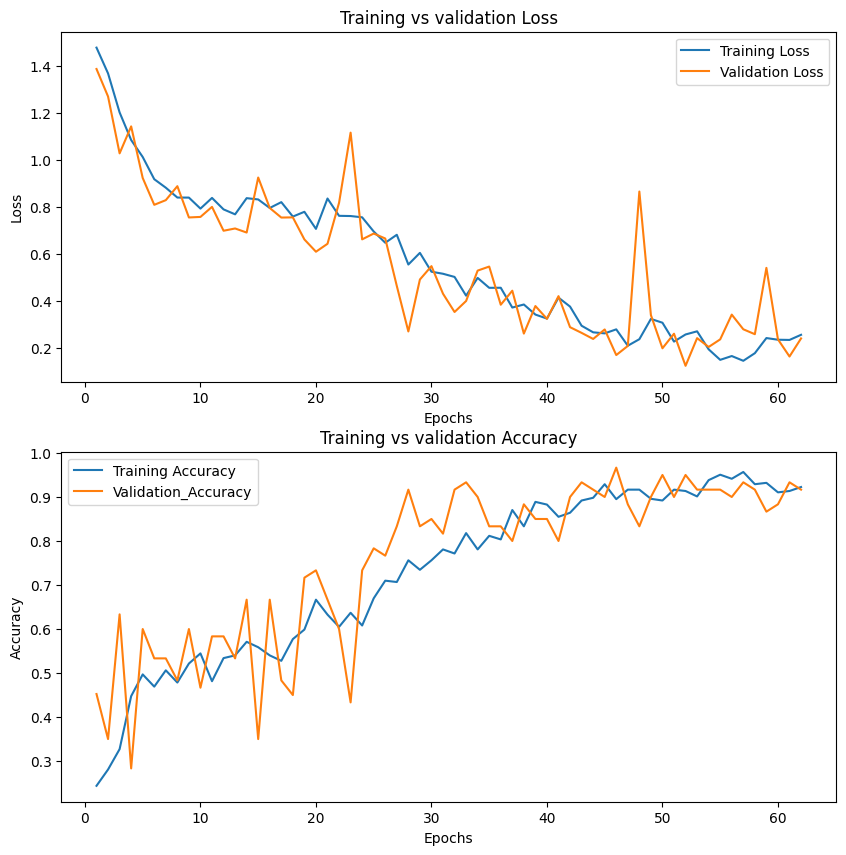

In [52]:
plt.figure(figsize=(10,10))

# Getting the exact number of epochs that our model
loss_values = history_dict['loss']
epochs_range = range(1, len(loss_values) + 1)

# Plotting training vs validation Loss
plt.subplot(2,1,1)
plt.title('Training vs validation Loss')
plt.plot(epochs_range, history.history['loss'])
plt.plot(epochs_range, history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

# Plotting training vs validation Accuracy
plt.subplot(2,1,2)
plt.title('Training vs validation Accuracy')
plt.plot(epochs_range, history.history['accuracy'])
plt.plot(epochs_range, history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation_Accuracy'])

In [49]:
# testing every single image from the testing folder
test_folder = r'C:\Users\Desktop\Bird\Testing'

# iterate through all the folders that we have in testing directory
for folder in os.listdir(test_folder):
    predictions = []
    print('Class: ', folder)
    test_images = os.path.join(test_folder, folder)
    # iterate through all the inmages that we have in a particular testing folder
    for img in os.listdir(test_images):
        image = load_img(os.path.join(test_images, img), target_size=(150, 150))
        # converting image to an array
        image = img_to_array(image)
    
        image = np.expand_dims(image, axis=0)
        # rescaling
        image = image / 255.0
        # predicting the output 
        prediction = model.predict(image)
        # getting the particular class name for that image
        class_name = list(train_dataset.class_indices.keys())[list(train_dataset.class_indices.values()).index(np.argmax(prediction))]
        
        predictions.append({img: class_name})

    for prediction in predictions:
        for img_name, class_name in prediction.items():
            print(f"Image Number: {img_name}, Actual Class: {folder}, Predicted Class: {class_name}")
    print('\n-------------------------------------------------------------\n')

Class:  PAINTED BUNTIG
1/1 [==============================] - 0s 26ms/step
Image Number: 001.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAINTED BUNTIG
Image Number: 002.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAINTED BUNTIG
Image Number: 003.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAINTED BUNTIG
Image Number: 004.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAINTED BUNTIG
Image Number: 005.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAINTED BUNTIG
Image Number: 006.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAINTED BUNTIG
Image Number: 007.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAINTED BUNTIG
Image Number: 008.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAINTED BUNTIG
Image Number: 009.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAINTED BUNTIG
Image Number: 010.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: RAINBOW LORIKEET
Image Number: 011.jpg, Actual Class: PAINTED BUNTIG, Predicted Class: PAI